In [3]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [29]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [5]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [6]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [7]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [8]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [9]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [20]:

N = 250
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.9
ϵ = 0.1
x = [20, 60, 90, 1, 1];
λ = 0.9
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 5000
epochsize = 500

total = 0
rando = 0
rando += uu[2]
k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
u = uu[1]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if (counter % epochsize == 0) || (xp[1] <= 10)
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
        #ϵ = max(75-counter/(1.3e6),0)
        running_avg = mean(totals)
        if running_avg > 0 
            k = max(running_avg, 1)
        else
            k = 1
        end
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current47_2.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 50.0 AVG: 23.67 Epoch: 1808 -----------
--------- CURRENT: 50.0 AVG: 30.25 Epoch: 1809 -----------
--------- CURRENT: 50.0 AVG: 34.2 Epoch: 1810 -----------
--------- CURRENT: 50.0 AVG: 36.83 Epoch: 1811 -----------
--------- CURRENT: 50.0 AVG: 38.71 Epoch: 1812 -----------
--------- CURRENT: 50.0 AVG: 40.13 Epoch: 1813 -----------
--------- CURRENT: 50.0 AVG: 41.22 Epoch: 1814 -----------
--------- CURRENT: 50.0 AVG: 42.1 Epoch: 1815 -----------
--------- CURRENT: 50.0 AVG: 42.82 Epoch: 1816 -----------
--------- CURRENT: 50.0 AVG: 43.42 Epoch: 1817 -----------
--------- CURRENT: 50.0 AVG: 43.92 Epoch: 1818 -----------
--------- CURRENT: 50.0 AVG: 44.36 Epoch: 1819 -----------
--------- CURRENT: 50.0 AVG: 44.73 Epoch: 1820 -----------
--------- CURRENT: 50.0 AVG: 45.06 Epoch: 1821 -----------
--------- CURRENT: 50.0 AVG: 45.35 Epoch: 1822 -----------
--------- CURRENT: 50.0 AVG: 45.61 Epoch: 1823 -----------
--------- CURRENT: 50.0 AVG: 45.84 Epoch: 1824 -----------

--------- CURRENT: 46.2 AVG: 40.28 Epoch: 1941 -----------
--------- CURRENT: 50.0 AVG: 40.34 Epoch: 1942 -----------
--------- CURRENT: 8.3 AVG: 40.12 Epoch: 1943 -----------
--------- CURRENT: 50.0 AVG: 40.19 Epoch: 1944 -----------
--------- CURRENT: 48.8 AVG: 40.25 Epoch: 1945 -----------
--------- CURRENT: 2.6 AVG: 39.99 Epoch: 1946 -----------
--------- CURRENT: 50.0 AVG: 40.06 Epoch: 1947 -----------
--------- CURRENT: 50.0 AVG: 40.13 Epoch: 1948 -----------
--------- CURRENT: 50.0 AVG: 40.19 Epoch: 1949 -----------
--------- CURRENT: 50.0 AVG: 40.26 Epoch: 1950 -----------
--------- CURRENT: 36.2 AVG: 40.23 Epoch: 1951 -----------
--------- CURRENT: 50.0 AVG: 40.3 Epoch: 1952 -----------
--------- CURRENT: 39.2 AVG: 40.29 Epoch: 1953 -----------
--------- CURRENT: 50.0 AVG: 40.35 Epoch: 1954 -----------
--------- CURRENT: 50.0 AVG: 40.41 Epoch: 1955 -----------
--------- CURRENT: 50.0 AVG: 40.47 Epoch: 1956 -----------
--------- CURRENT: 50.0 AVG: 40.53 Epoch: 1957 -----------


In [31]:
θ = convert(Matrix, CSV.read("current473.csv"));
totals = [0.0]

1-element Array{Float64,1}:
 0.0

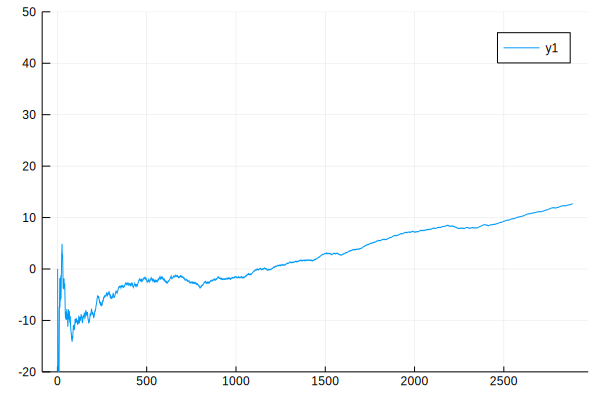

In [16]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-20,50))

In [10]:
#θ = convert(Matrix, CSV.read("good.csv"))


28080×6 Array{Float64,2}:
  0.106108  0.0  -0.0829134  0.0   0.0743955  0.0
 -0.218553  0.0  -1.1224     0.0  -0.0545906  0.0
  0.326478  0.0  -1.73706    0.0  -0.277184   0.0
  0.908624  0.0  -1.52726    0.0   0.388403   0.0
  0.697881  0.0   0.670758   0.0   0.861652   0.0
 -0.10886   0.0  -1.74887    0.0   0.265702   0.0
  0.375173  0.0   1.65491    0.0   0.651283   0.0
  1.15377   0.0   6.51786    0.0   1.21614    0.0
  1.19869   0.0   5.65495    0.0  -0.0774921  0.0
  3.01445   0.0   9.6408     0.0  -0.425889   0.0
  4.68788   0.0   7.16558    0.0   1.04943    0.0
  4.66821   0.0   3.13691    0.0   1.33348    0.0
  6.16342   0.0   2.09777    0.0   1.28498    0.0
  ⋮                                           ⋮  
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0   

In [18]:
θ = convert(Matrix, thetaframe)

28080×6 Array{Float64,2}:
 -1.77704    0.0  -3.91139    0.0  -1.6716    0.0
  0.104306   0.0  -0.277353   0.0   0.29317   0.0
  0.0992801  0.0   2.52568    0.0   1.46481   0.0
  0.892081   0.0   2.81689    0.0   1.36093   0.0
  0.633067   0.0   0.479396   0.0   0.563874  0.0
  1.14868    0.0   0.109032   0.0   0.678002  0.0
  0.651611   0.0  -0.0357058  0.0   0.760664  0.0
  1.14689    0.0   1.85016    0.0   0.111559  0.0
  1.16463    0.0   0.581399   0.0   0.865836  0.0
  1.1367     0.0   1.04617    0.0   1.66769   0.0
  0.345221   0.0   0.929168   0.0   0.788199  0.0
  0.681581   0.0   1.02612    0.0   0.704559  0.0
  0.978036   0.0   0.321273   0.0   1.28954   0.0
  ⋮                                           ⋮  
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0  

In [25]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_11.28_1", thetaframe)

"0.44_theta_11.28_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5